# Main Supervisor 

In [1]:
import sys
sys.path.append('../')


import uuid

######### React agent ############
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate

###### From config #######
from config import Config
conf = Config()

####### From Resources #####
from utils.resource_manager import ResourceManager
resource_manager = ResourceManager.get_instance()

import pandas as pd


##### Agent ##############
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool
from agents.news_agent import news_agent
from agents.search_agent import search_agent
from agents.central_memory_agent import central_memory_agent



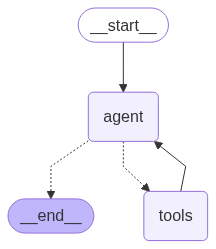

In [2]:
news_agent

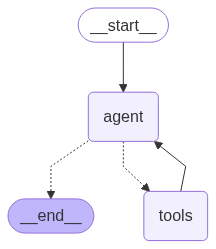

In [3]:
search_agent

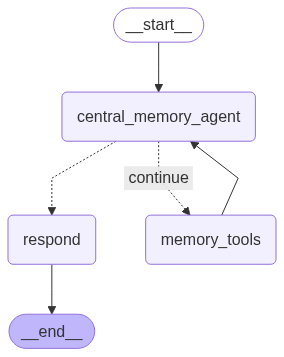

In [4]:
central_memory_agent

# Supervisor 

## Prompt (Build Using Langchain)

In [5]:
try:
    long_term_memory = pd.read_csv(f"{conf.memory_path}/Permanent_Memory.csv")

except:
    long_term_memory = pd.DataFrame()

try:    
    reminders = pd.read_csv(f"{conf.memory_path}/Reminders.csv")

except:
    reminders = pd.DataFrame()

In [6]:
long_term_memory_str = long_term_memory.to_json(orient='records', indent=4)
reminders_str = reminders.to_json(orient='records', indent=4)

In [7]:

prompt_blueprint = resource_manager.prompt_loader("supervisor_prompt")

prompt_template = PromptTemplate.from_template(prompt_blueprint)
prompt = prompt_template.invoke({"ToolMessage": '{"tool":"forwarded_response","args":{"from_agent":"news_agent"}}',
                            "long_term_memory_string": long_term_memory_str,
                            "reminder_string": reminders_str}).to_string()

print(prompt)

You are Ryo, intelligent health and lifestyle supervisor overseeing three specialized agents:
- News Agent: Fetches up-to-date news articles.
- Web agents: Retrieves general web articles, reference pages, or informational content.
- Central Memory Agent: Maintains and retrieves relevant long-term memories to inform and personalize conversations.

<Agent Instructions>
1. Classify the user query:
   - If it’s about current events or headlines, invoke News Agent.
   - If it’s seeking background information or explanatory articles, invoke Web Agent.
   - If its asking to remember a memory, set a reminder or to recall a memory, invoke Central Memory Agent.
   - Handle combined queries (e.g., “News + background”) by first using News Agent then using Web Agent.

2. Delegation protocol**:
   - Use `transfer_to_<agent_name>` tool to pass control.
   - Wait for each agent’s response before deciding if further routing is required.

<Routing Instructions>
1. When News Agent returns a fully-formed 

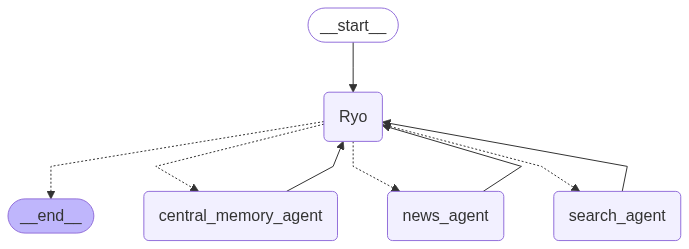

In [8]:
forwarding_tool = create_forward_message_tool("forwarded_response")

graph = create_supervisor([news_agent, central_memory_agent, search_agent], 
                        model=conf.model, 
                        supervisor_name='Ryo',
                        prompt=prompt,
                        tools=[forwarding_tool],
                        output_mode='last_message')
ryo = graph.compile(checkpointer=InMemorySaver())
ryo



In [11]:
# result = ryo.invoke(
#     {"messages": [{"role": "user", "content": "Remember my name is Siddharth"}]},
#     conf.ryo_configs
# )

# result

In [17]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "Remember my name is Siddharth"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

Remember my name is Siddharth
================================== Ai Message ==================================
Name: Ryo

I've already remembered your name as Siddharth. Is there anything else you would like me to remember or assist you with?


[HumanMessage(content='Remember my name is Siddharth', additional_kwargs={}, response_metadata={}, id='a78bfe1b-02ea-4520-a570-97a45322c5b7'),
 AIMessage(content="I've already remembered your name as Siddharth. Is there anything else you would like me to remember or assist you with?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1724, 'total_tokens': 1750, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1664}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnKTHXojX0WYY6E1QKHEGqeuyWg9L', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Ryo', id='run--6efff031-9ef5-4270-93af-768002084b80-0', usage_metadata={'input_tokens': 1724, 'output_tokens': 26, 'total_tokens': 1750, 'input_token_details': {'au

In [18]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "Remind me to learn driving by Tomorrow"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Remind me to learn driving by Tomorrow
================================= Tool Message =================================
Name: transfer_to_central_memory_agent

Successfully transferred to central_memory_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

I've set a reminder for you to learn driving by tomorrow. If there's anything else you need, just let me know!


[HumanMessage(content='Remind me to learn driving by Tomorrow', additional_kwargs={}, response_metadata={}, id='8cbcc776-66e0-4bec-8922-004f3c428ea4'),
 ToolMessage(content='Successfully transferred to central_memory_agent', name='transfer_to_central_memory_agent', id='36e8a815-9572-4688-addc-b03296194783', tool_call_id='call_vxfdruUW0HthKmSy5seDe8Mw'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='7dbdbe17-f4d2-4041-bcda-eecf7fd49e63', tool_call_id='a6d42a09-f0ba-49d1-9868-591b83fd290e'),
 AIMessage(content="I've set a reminder for you to learn driving by tomorrow. If there's anything else you need, just let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 570, 'total_tokens': 595, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 

In [19]:
ryo.invoke(
    {"messages": [{"role": "user", "content": "What are my reminders?"}]},
    conf.ryo_configs
)

{'messages': [HumanMessage(content='Remember my name is Siddharth', additional_kwargs={}, response_metadata={}, id='0bea3300-0dd7-4f4a-9fe8-d3a9ab28ab52'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dtzRfH7gc3VdZVkTyJt2NtWf', 'function': {'arguments': '{}', 'name': 'transfer_to_central_memory_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 298, 'total_tokens': 312, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BnJWa6qVJzazml5CCEBjB92zifqNk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Ryo', id='run--0e62f21c-84f4-415d-b2a1-f34467a87e4e-0', tool_calls=[{'name': 'transfer_to_central_memory_agent', 'a

In [ ]:
ryo.invoke(
    {"messages": [{"role": "user", "content": "What did I ask just now?"}]},
    conf.ryo_configs
)

{'messages': [HumanMessage(content='What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines', additional_kwargs={}, response_metadata={}, id='c9c683c5-5261-4271-acb8-90ba45b0e410'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KTZsqLXo3DnhVckQlrtAutUG', 'function': {'arguments': '{}', 'name': 'transfer_to_news_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 189, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnH3UpfjOEhYulhB8guE4q8i0jJb5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs

In [9]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content":  "What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines
================================= Tool Message =================================
Name: transfer_to_news_agent

Successfully transferred to news_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: forwarded_response

Here's a roundup of the latest news headlines from this past week in the United States, covering politics, sports, technology, and artificial intelligence:

### Politics
1. **Trump Ramps Up Pressure Amid GOP Tensions Over His Bill** 
   - **Context**: Former President Donald Trump is increasing pressure on GOP lawmakers about legislation he s

[HumanMessage(content='What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines', additional_kwargs={}, response_metadata={}, id='ea30317b-5770-43de-97bb-211c057a5ac8'),
 ToolMessage(content='Successfully transferred to news_agent', name='transfer_to_news_agent', id='7c9b27ca-4488-4c64-bef9-e9e8433cac8c', tool_call_id='call_5vMI9ZkHlD9eS1nTuTgu8uGn'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='e9c2edcc-8049-427a-bbba-c5ebb1b2e0a3', tool_call_id='eb47f704-3fc8-4991-9001-6f81839dabce'),
 AIMessage(content="Here's a roundup of the latest news headlines from this past week in the United States, covering politics, sports, technology, and artificial intelligence:\n\n### Politics\n1. **Trump Ramps Up Pressure Amid GOP Tensions Over His Bill** \n   - **Context**: Former President Donald Trump is increasing pressure on GOP lawmakers

In [ ]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "what is the latest news"}]},
    conf.ryo_configs, stream_mode="values")
)


================================ Human Message =================================

what is the latest news
================================ Human Message =================================

what is the latest news
================================== Ai Message ==================================
Name: news_agent

Here are some of the latest news updates across various sectors:

1. **Investment and Business:**
   - **Villa Rental Platform Stayvista**: JSW Ventures has led a ₹40 crore investment round in the villa rental platform Stayvista. [Read more](https://startupnews.fyi/2025/06/28/the-founders-of-01a-share-their-playbook-at-disrupt-2025/).
   - **China's Fashion Retailer Shein**: Shein is reportedly planning to file confidentially for an IPO in Hong Kong, which is considered a rare move. [Read more](https://startupnews.fyi/2025/06/28/the-founders-of-01a-share-their-playbook-at-disrupt-2025/).

2. **Technology:**
   - **Tesla**: Tesla's robotaxi rollout is facing its first real test, wi

[HumanMessage(content='what is the latest news', additional_kwargs={}, response_metadata={}, id='1e997e09-1cd9-4ae5-b798-63d4094e5b2f'),
 HumanMessage(content='what is the latest news', additional_kwargs={}, response_metadata={}, id='1e997e09-1cd9-4ae5-b798-63d4094e5b2f'),
 AIMessage(content="Here are some of the latest news updates across various sectors:\n\n1. **Investment and Business:**\n   - **Villa Rental Platform Stayvista**: JSW Ventures has led a ₹40 crore investment round in the villa rental platform Stayvista. [Read more](https://startupnews.fyi/2025/06/28/the-founders-of-01a-share-their-playbook-at-disrupt-2025/).\n   - **China's Fashion Retailer Shein**: Shein is reportedly planning to file confidentially for an IPO in Hong Kong, which is considered a rare move. [Read more](https://startupnews.fyi/2025/06/28/the-founders-of-01a-share-their-playbook-at-disrupt-2025/).\n\n2. **Technology:**\n   - **Tesla**: Tesla's robotaxi rollout is facing its first real test, with potenti

In [11]:
result = ryo.invoke(
    {"messages": [{"role": "user", "content": "what is the latest news"}]},
    conf.ryo_configs
)

In [ ]:
result['messages'][-1].content

"Here are some of the latest news headlines from today in the United States:\n\n1. **Amber Alert Issued for Idaho Teens with Religious Polygamy Group**\n   - **Source**: [USA Today](https://www.usatoday.com/story/news/nation/2025/06/27/amber-alert-missing-idaho-teens-allen-rachelle-fischer/84383702007/)\n   - **Context**: An Amber Alert has been issued for two missing teenagers from Idaho, who are feared to be with a religious polygamy group. The situation is raising concerns about the safety and well-being of the teens.\n\n2. **Key Data Cuts in Hurricane Forecasting Raise Concerns**\n   - **Source**: [AP News](https://apnews.com/article/climate-hurricane-forecasting-weather-defense-satellites-ea4cdb91c891255add2e9a94c28606ef)\n   - **Context**: The U.S. government has reduced key data crucial for hurricane forecasting, sparking alarm among experts. The cuts might affect preparedness and response to future hurricanes.\n\n3. **Possible Meteor Over Southeast**\n   - **Source**: [ABC News

In [18]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "Can you find articles on me?"}]},
    conf.ryo_configs, stream_mode="values")
)

================================ Human Message =================================

Can you find articles on me?
================================= Tool Message =================================
Name: transfer_to_search_agent

Successfully transferred to search_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

I found some information related to you, Siddharth, as an AI/ML Applied Scientist at JPMorgan Chase:

1. **LinkedIn Profile:**
   - Offers an overview of your role and achievements, such as developing a risk ranking model. [View on LinkedIn](https://www.linkedin.com/in/siddharthmandgi).

2. **Professional Overview:**
   - Details your career path as an Applied AI ML Analyst at JPMorgan Chase. [Explore More](https://www.zoominfo.com/p/Siddharth-Sharma/8822991271).

3. **JPMorgan Chase AI/ML Im

[HumanMessage(content='Can you find articles on me?', additional_kwargs={}, response_metadata={}, id='27ddf0aa-c673-4dec-b950-e8af9d217f7c'),
 ToolMessage(content='Successfully transferred to search_agent', name='transfer_to_search_agent', id='afe1fe8d-0fe1-478b-a1af-755f0d67672b', tool_call_id='call_5GTxjbFRaNnPQyG4RoWhsK9A'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='00b5bb33-d05a-4fef-bc69-18c815f78d9c', tool_call_id='2f159c21-3dc2-40f2-8f09-0529f1b3842f'),
 AIMessage(content='I found some information related to you, Siddharth, as an AI/ML Applied Scientist at JPMorgan Chase:\n\n1. **LinkedIn Profile:**\n   - Offers an overview of your role and achievements, such as developing a risk ranking model. [View on LinkedIn](https://www.linkedin.com/in/siddharthmandgi).\n\n2. **Professional Overview:**\n   - Details your career path as an Applied AI ML Analyst at JPMorgan Chase. [Explore More](https://www.zoominfo.com/p/Siddharth-Sharma/88

In [9]:
resource_manager.stream_agent(ryo.stream(
    {"messages": [{"role": "user", "content": "Who am I?"}]},
    conf.ryo_configs, stream_mode="values"))

================================ Human Message =================================

Who am I?
================================= Tool Message =================================
Name: transfer_to_central_memory_agent

Successfully transferred to central_memory_agent
================================= Tool Message =================================
Name: transfer_back_to_ryo

Successfully transferred back to Ryo
================================== Ai Message ==================================
Name: Ryo

Your name is Siddharth, and you are an AI/ML Applied Scientist at JPMorgan Chase. If there's anything else you'd like to know or update, feel free to let me know!


[HumanMessage(content='Who am I?', additional_kwargs={}, response_metadata={}, id='d398d473-3389-4b84-a0a1-88ad84557d1c'),
 ToolMessage(content='Successfully transferred to central_memory_agent', name='transfer_to_central_memory_agent', id='e1a65db1-df97-4cae-bfcc-f80725ec35ad', tool_call_id='call_pzFN3gU4R4qotZ82q1OK2v4A'),
 ToolMessage(content='Successfully transferred back to Ryo', name='transfer_back_to_ryo', id='a0763e63-4797-4bd3-bdb3-bd51c65f3030', tool_call_id='cd472226-0884-412c-8b7f-46fbc8a59b3f'),
 AIMessage(content="Your name is Siddharth, and you are an AI/ML Applied Scientist at JPMorgan Chase. If there's anything else you'd like to know or update, feel free to let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 928, 'total_tokens': 968, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details